In [30]:
import shap
shap.initjs()

import matplotlib.pyplot as plt
import numpy as np

from alibi.explainers import KernelShap
from sklearn import svm
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [31]:
wine = load_wine()
wine.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [32]:
data = wine.data
target = wine.target
target_names = wine.target_names
feature_names  = wine.feature_names
print(target_names)
print(feature_names)

['class_0' 'class_1' 'class_2']
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 142
Testing records: 36


In [5]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [6]:
np.random.seed(0)
classifier = SVC(
    kernel = 'rbf',
    C=1,
    gamma = 0.1,
    decision_function_shape='ovr',  # n_cls trained with data from one class as postive and remainder of data as neg
    random_state = 0,
)
classifier.fit(X_train_norm, y_train)

SVC(C=1, gamma=0.1, random_state=0)

In [7]:
y_pred = classifier.predict(X_test_norm)
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion matrix for SVC classifier')

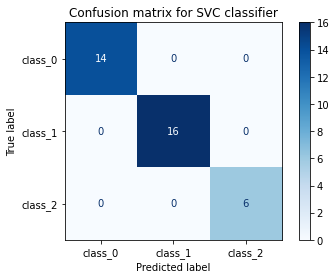

In [8]:
title = 'Confusion matrix for SVC classifier'
disp = plot_confusion_matrix(classifier,
                             X_test_norm,
                             y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

In [9]:
pred_fcn = classifier.decision_function

In [10]:
np.random.seed(0)
svm_explainer = KernelShap(pred_fcn)
svm_explainer.fit(X_train_norm)

Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [11]:
# expected_values attribute stores average scores across training set for every binary SVM
mean_scores_train = pred_fcn(X_train_norm).mean(axis=0)
# are stored in the expected value attibute of the explainer ...
print(mean_scores_train - svm_explainer.expected_value)

[-1.11022302e-16  4.44089210e-16 -2.22044605e-16]


In [12]:
svm_explanation = svm_explainer.explain(X_test_norm, l1_reg=False)

  0%|          | 0/36 [00:00<?, ?it/s]

In [13]:
print("Output type:", type(svm_explanation.shap_values))
print("Output size:", len(svm_explanation.shap_values))
print("Class output size:", svm_explanation.shap_values[0].shape)

Output type: <class 'list'>
Output size: 3
Class output size: (36, 13)


In [14]:
idx =  0
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)
scores =  classifier.decision_function(instance)
class_idx = pred.item()
print("The predicted class for the X_test_norm[{}] is {}.".format(idx, *pred))
print("OVR decision function values are {}.".format(*scores))

The predicted class for the X_test_norm[0] is 0.
OVR decision function values are [ 2.24071294  0.85398239 -0.21510456].


In [15]:
shap.force_plot(
    svm_explainer.expected_value[class_idx],
    svm_explanation.shap_values[class_idx][idx, :] ,
    instance,
    feature_names,
)

In [16]:
shap.force_plot(
    svm_explainer.expected_value[1],
    svm_explanation.shap_values[1][idx, :] ,
    instance,
    feature_names,
)

In [17]:
def class_labels(classifier, instance, class_names=None):
    """
    Creates a set of legend labels based on the decision
    scores of a classifier and, optionally, the class names.
    """

    decision_scores = classifier.decision_function(instance)

    if not class_names:
        class_names = [f'Class {i}' for i in range(decision_scores.shape[1])]

    for i, score in enumerate(np.nditer(decision_scores)):
        class_names[i] = class_names[i] + ' ({})'.format(round(score.item(),3))

    return class_names

In [18]:
legend_labels = class_labels(classifier, instance)

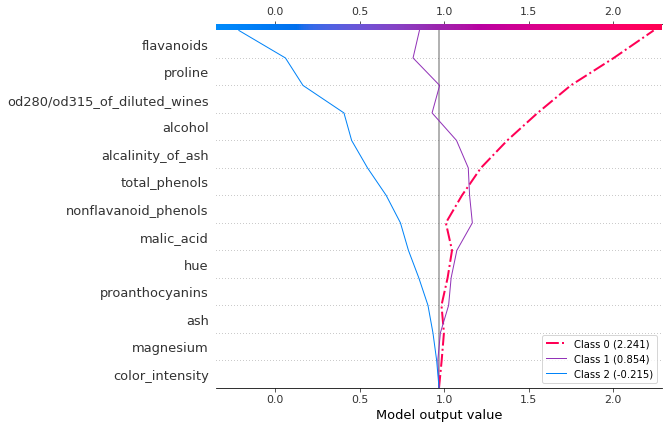

In [19]:
r = shap.multioutput_decision_plot(svm_explainer.expected_value.tolist(),
                                   svm_explanation.shap_values,
                                   idx,
                                   feature_names=feature_names,
                                   feature_order='importance',
                                   highlight=[class_idx],
                                   legend_labels=legend_labels,
                                   return_objects=True,
                                   legend_location='lower right')

In [20]:
idx =  5
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)

In [21]:
instance_shap = np.array(svm_explanation.shap_values)[:, idx, :]
feature_order = np.argsort(np.sum(np.abs(instance_shap),axis=0))[::-1]
feat_importance = [feature_names[i] for i in feature_order]
feat_importance

['flavanoids',
 'alcalinity_of_ash',
 'od280/od315_of_diluted_wines',
 'alcohol',
 'ash',
 'total_phenols',
 'proline',
 'proanthocyanins',
 'magnesium',
 'hue',
 'malic_acid',
 'color_intensity',
 'nonflavanoid_phenols']

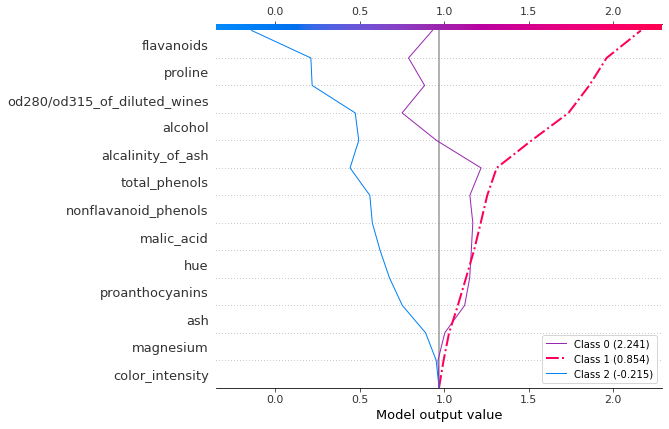

In [22]:
shap.multioutput_decision_plot(svm_explainer.expected_value.tolist(),
                               svm_explanation.shap_values,
                               idx,
                               feature_names=feature_names,
                               feature_order=r.feature_idx,
                               highlight=[pred.item()],
                               legend_labels=legend_labels,
                               legend_location='lower right',
                               xlim=r.xlim,
                               return_objects=False)

In [23]:
class_idx = 0 # we explain the predicted label
shap.force_plot(
    svm_explainer.expected_value[class_idx],
    svm_explanation.shap_values[class_idx],
    X_test_norm,
    feature_names,
)


In [24]:
shap.force_plot(
    svm_explainer.expected_value[class_idx],
    svm_explanation.shap_values[class_idx],
    X_test_norm,
    feature_names,
)

In [25]:
shap.force_plot(
    svm_explainer.expected_value[0],
    svm_explanation.shap_values[0],
    X_test_norm,
    feature_names,
)

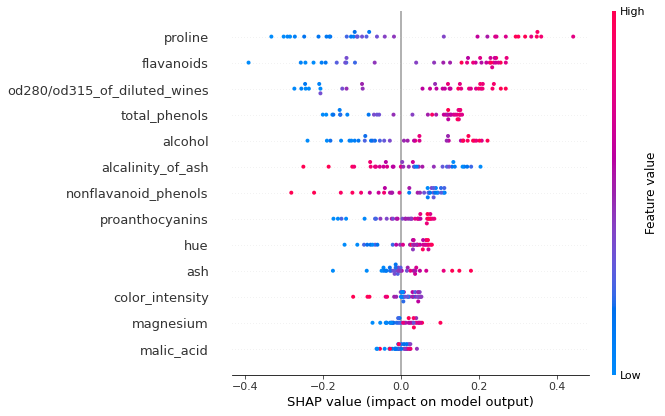

In [26]:
shap.summary_plot(svm_explanation.shap_values[0], X_test_norm, feature_names)

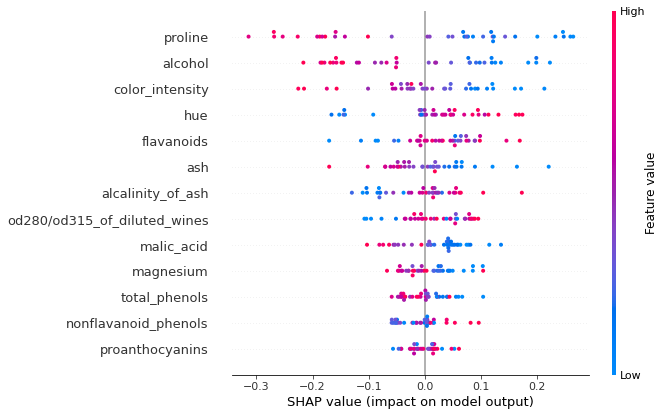

In [27]:
shap.summary_plot(svm_explanation.shap_values[1], X_test_norm, feature_names)

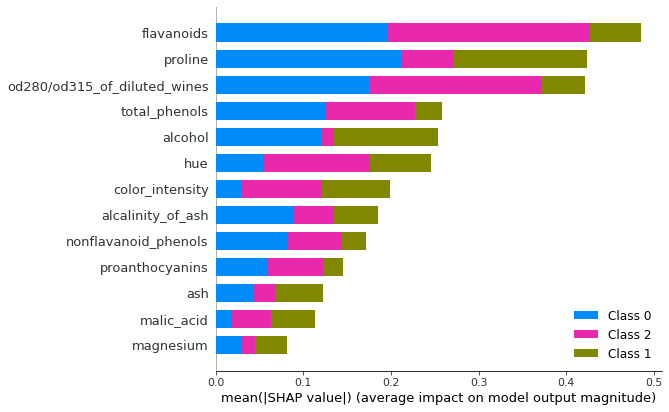

In [28]:
shap.summary_plot(svm_explanation.shap_values, X_test_norm, feature_names)

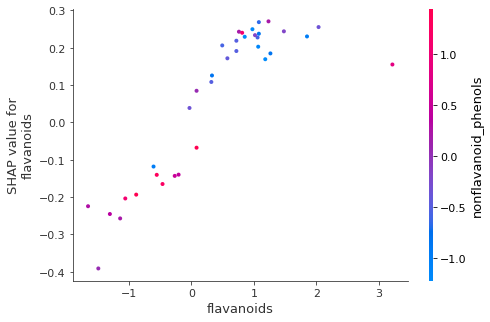

In [29]:
feature = 'flavanoids'
shap.dependence_plot(
    feature,
    svm_explanation.shap_values[0],
    X_test_norm,
    feature_names=feature_names,
    interaction_index='auto',
)